In [222]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

pd.options.mode.chained_assignment = None

### Step 1:	
Read in the three csv files as data frames. Combine all three data frames using admission_id into one named all_df, retaining all rows from Admissions.csv.

In [99]:
admin_df = pd.read_csv('C:/Users/rparg/Documents/Data/hospital_prediction/Admissions.csv').set_index('admission_id')
lab_df = pd.read_csv('C:/Users/rparg/Documents/Data/hospital_prediction/Lab.csv').set_index('admission_id')
tran_df = pd.read_csv('C:/Users/rparg/Documents/Data/hospital_prediction/Transfusions.csv').set_index('admission_id')

In [100]:
# Combine date and time columns together
admin_df['admission_time'] = admin_df['admission_time'].fillna('12:00')

admin_df['admin_datetime'] = pd.to_datetime(admin_df['admission_date'] + ' ' + admin_df['admission_time'])

admin_df['disch_datetime'] = pd.to_datetime(admin_df['discharge_date'] + ' ' + admin_df['discharge_time'])

admin_df['stay_datetime'] = (admin_df['disch_datetime'] - admin_df['admin_datetime'])

In [101]:
#Length of stay in days
admin_df['len_stay'] = (pd.to_datetime(admin_df['discharge_date']) - pd.to_datetime(admin_df['admission_date'])).dt.days

#Drops rows with invalid (<=0) len_stay
admin_df = admin_df[((admin_df['len_stay'] >0) & (admin_df['age'] < 100) & (admin_df['age'] >15))]

In [102]:
#Comorbidity Index
admin_df['charlson_comorbidity_index'].replace({'0':0,'1':1,'2+':2}, inplace = True)

#One Hot Sex
admin_df['sex'].replace({'M':0,'F':1}, inplace = True)

In [103]:
#One Hot Hospital
admin_df = admin_df.join(pd.get_dummies(admin_df['hospital']))

In [104]:
#One Hot Lab
lab_df = lab_df.join(pd.get_dummies(lab_df['test_code']))

In [105]:
#Transfusion Bool to int
tran_df[['rbc_transfusion','platelet_transfusion','plasma_transfusion']] = tran_df[['rbc_transfusion','platelet_transfusion','plasma_transfusion']].astype(int)

In [106]:
# Join together
all_df = admin_df.join([lab_df,tran_df], how = 'left', sort = True)

In [107]:
all_df['age'].value_counts()

54.0    365
56.0    363
55.0    358
57.0    335
53.0    319
58.0    304
52.0    297
51.0    287
59.0    268
50.0    229
60.0    227
61.0    173
49.0    169
48.0    140
62.0    133
63.0    108
47.0    103
46.0     78
64.0     61
65.0     51
45.0     50
44.0     46
66.0     34
67.0     26
43.0     19
42.0     14
68.0     10
41.0      9
70.0      8
39.0      4
69.0      4
40.0      2
71.0      2
72.0      1
73.0      1
74.0      1
38.0      1
Name: age, dtype: int64

In [108]:
all_df[['ALB', 'CLPL', 'CREAPL', 'KPL', 'NAPL', 'PLT', 'RBC', 'TCO2PL',
    'UREAPL','rbc_transfusion', 'platelet_transfusion', 'plasma_transfusion']] = all_df[['ALB', 
    'CLPL', 'CREAPL', 'KPL', 'NAPL', 'PLT', 'RBC', 'TCO2PL', 'UREAPL','rbc_transfusion',
    'platelet_transfusion', 'plasma_transfusion']].fillna(0)

#### EDA

In [109]:
admin_df.head()

,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,admin_datetime,disch_datetime,stay_datetime,len_stay,Mount Sinai Hospital,St. Joseph's Health Centre,St. Michael's Hospital,Sunnybrook Health Sciences Centre,Toronto Western Hospital
admission_id,,,,,,,,,,,,,,,,,,,
2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,0,1.0,46,2008-07-22 06:19:00,2008-07-24 17:54:00,2 days 11:35:00,2,0,0,1,0,0
8755,97765,2002-08-24,14:28,08/27/2002,08:14,Mount Sinai Hospital,59.0,1,0.0,35,2002-08-24 14:28:00,2002-08-27 08:14:00,2 days 17:46:00,3,1,0,0,0,0
9260,17941,2007-01-12,09:39,01/26/2007,11:10,Sunnybrook Health Sciences Centre,57.0,0,1.0,18,2007-01-12 09:39:00,2007-01-26 11:10:00,14 days 01:31:00,14,0,0,0,1,0
5317,36532,2003-09-24,13:37,10/12/2003,16:23,Toronto Western Hospital,51.0,1,1.0,21,2003-09-24 13:37:00,2003-10-12 16:23:00,18 days 02:46:00,18,0,0,0,0,1
9629,67061,2014-12-08,20:02,12/13/2014,02:53,Toronto Western Hospital,53.0,1,NaN,42,2014-12-08 20:02:00,2014-12-13 02:53:00,4 days 06:51:00,5,0,0,0,0,1


In [110]:
admin_grouped_by_age_df = admin_df.groupby('age',as_index=False).agg({"charlson_comorbidity_index":lambda x: x.isnull().sum(),'patient_id':'count',"admission_time":lambda x: x.isnull().sum()})
admin_grouped_by_age_df['charlson_null_fraction'] = admin_grouped_by_age_df['charlson_comorbidity_index']/admin_grouped_by_age_df['patient_id']
admin_grouped_by_age_df['admission_time_null_fraction'] = admin_grouped_by_age_df['admission_time']/admin_grouped_by_age_df['patient_id']
admin_grouped_by_age_df['age'] = admin_grouped_by_age_df['age'].astype(int)

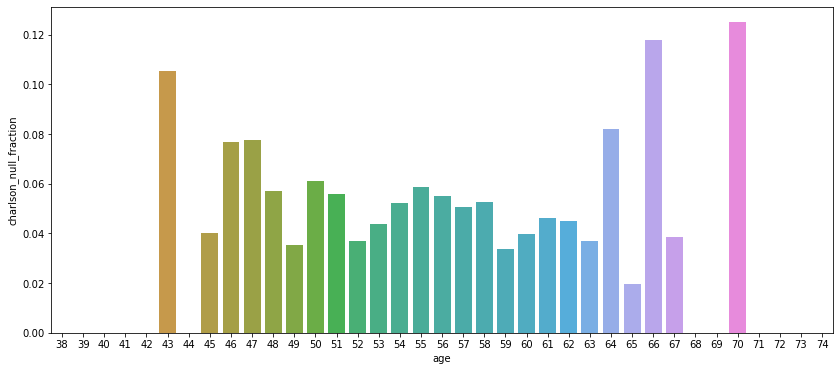

In [111]:
f,ax = plt.subplots(figsize=(14,6))
sns.barplot(data = admin_grouped_by_age_df, x='age', y='charlson_null_fraction' ,ax=ax)
plt.show()

In [112]:
admin_grouped_by_hospital_df = admin_df.groupby('hospital',as_index=False).agg({"age":lambda x: x.isnull().sum(),'patient_id':'count'})
admin_grouped_by_hospital_df['age_fraction'] = admin_grouped_by_hospital_df['age']/admin_grouped_by_hospital_df['patient_id']

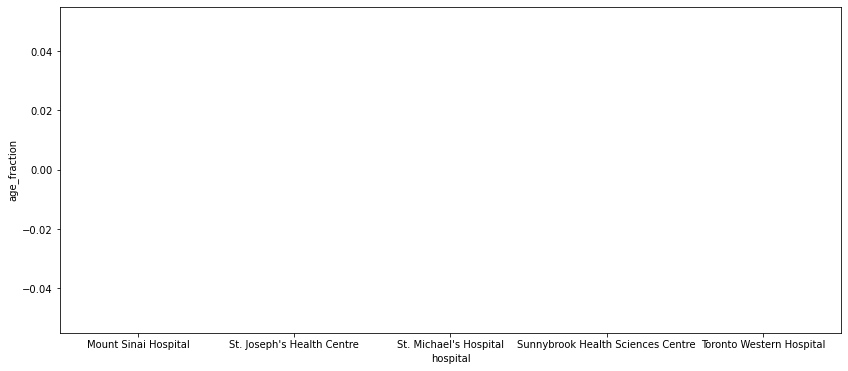

In [113]:
f,ax = plt.subplots(figsize=(14,6))
sns.barplot(data = admin_grouped_by_hospital_df, x='hospital', y='age_fraction' ,ax=ax)
plt.show()

In [114]:
table = pd.DataFrame(admin_df[~admin_df["charlson_comorbidity_index"].isnull()].groupby("age").count()['patient_id']).join(admin_df[admin_df["charlson_comorbidity_index"].isnull()].groupby("age").count()['patient_id'], on='age', lsuffix='_notnull', rsuffix='_null').fillna(0)


In [115]:
print(table)

      patient_id_notnull  patient_id_null
age                                      
38.0                   1              0.0
39.0                   4              0.0
40.0                   2              0.0
41.0                   9              0.0
42.0                  14              0.0
43.0                  17              2.0
44.0                  46              0.0
45.0                  48              2.0
46.0                  72              6.0
47.0                  95              8.0
48.0                 132              8.0
49.0                 163              6.0
50.0                 215             14.0
51.0                 271             16.0
52.0                 286             11.0
53.0                 305             14.0
54.0                 346             19.0
55.0                 337             21.0
56.0                 343             20.0
57.0                 318             17.0
58.0                 288             16.0
59.0                 259          

In [116]:
chi2, p, dof, ex = chi2_contingency(table)
print("The p-value is esqual to {}".format(p))

The p-value is esqual to 0.9638727832760823


### Step 2:
Impute the missing age and charlson_comorbidity_index values in any way you see fit. Briefly explain how the imputation method(s) might affect a statistical model that uses these variables as predictors.

In [117]:
admin_df.isnull().sum()

patient_id                             0
admission_date                         0
admission_time                         0
discharge_date                         0
discharge_time                         0
hospital                               0
age                                    0
sex                                    0
charlson_comorbidity_index           228
lap_score                              0
admin_datetime                         0
disch_datetime                         0
stay_datetime                          0
len_stay                               0
Mount Sinai Hospital                   0
St. Joseph's Health Centre             0
St. Michael's Hospital                 0
Sunnybrook Health Sciences Centre      0
Toronto Western Hospital               0
dtype: int64

In [118]:
#KNNImputation of age and comorbidity index
imputer = KNNImputer(n_neighbors=2, weights="uniform")
all_df['stay_days'] = all_df['stay_datetime'].dt.days
imp_ad_df = imputer.fit_transform(all_df[['age','sex','charlson_comorbidity_index','lap_score','stay_days',
    'Mount Sinai Hospital',"St. Joseph's Health Centre","St. Michael's Hospital","Sunnybrook Health Sciences Centre",
    "Toronto Western Hospital",'ALB', 'CLPL', 'CREAPL', 'KPL', 'NAPL', 'PLT', 'RBC', 'TCO2PL','UREAPL',
    'rbc_transfusion', 'platelet_transfusion', 'plasma_transfusion']])

In [119]:
#Replace with imputed values
all_df['age'] = imp_ad_df[:,0]
all_df['charlson_comorbidity_index'] = imp_ad_df[:,2]
#Rounds down imputed values of age and charlson_comorbidity_index to int values
all_df[['age','charlson_comorbidity_index']] = all_df[['age','charlson_comorbidity_index']].apply(np.floor)

### Step 3:
Determine if there is a significant difference in age between patients who had an rbc_transfusion and patients that did not. Determine if there is a significant difference in sex between these groups.

In [120]:
table = pd.crosstab(all_df["rbc_transfusion"], all_df['age'])
stat, pvalue = ttest_ind(table.loc[0.0], table.loc[1.0])
print('the p-value is equal to {}'.format(pvalue))

the p-value is equal to 1.373613192286214e-06


Since the  p-value is less than 5%, we reject null hypothesis (H0) and the two variables are dependent.

In [121]:
table = pd.crosstab(all_df["rbc_transfusion"], all_df['sex'])
chi2, p, dof, ex = chi2_contingency(table)
print("The p-value is esqual to {}".format(p))
table

The p-value is esqual to 0.5065199557760587


sex,0.0,1.0
rbc_transfusion,,
0.0,1984,2281
1.0,149,186


Since the  p-value is greater that 5%, we fail to reject null hypothesis (H0) and the two variables are independent.

### Step 4:
Fit a linear regression model using the result_value of the “Platelet Count” lab tests as the dependent variable and age, sex, and hospital as the independent variables. Interpret the results.

In [122]:
plt_x_df = all_df[all_df['PLT']==1][['age','sex', 'Mount Sinai Hospital',
       "St. Joseph's Health Centre", "St. Michael's Hospital",
       'Sunnybrook Health Sciences Centre', 'Toronto Western Hospital']]
plt_y_df = all_df[all_df['PLT']==1]['result_value']

#check there are no nulls in vars
plt_x_df.isnull().sum()

age                                  0
sex                                  0
Mount Sinai Hospital                 0
St. Joseph's Health Centre           0
St. Michael's Hospital               0
Sunnybrook Health Sciences Centre    0
Toronto Western Hospital             0
dtype: int64

In [123]:
#Train test split before scaling
X_train, X_test, y_train, y_test = train_test_split(plt_x_df, plt_y_df, test_size=0.10, random_state=42069)

In [124]:
#Scale age to be between 0 and 1 for train and test sets seperately
scaler = MinMaxScaler()
age_train = X_train['age'].to_numpy().reshape(-1,1)
X_train.loc[:,'age'] = scaler.fit_transform(age_train)
age_test = X_test['age'].to_numpy().reshape(-1,1)
X_test.loc[:,'age'] = scaler.fit_transform(age_test)

In [125]:
#Train a linear regression and print the coefficients and score (R^2) for the test data
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
print(reg.score(X_test, y_test))

[-63.72665975 -30.77085356   6.1593788    2.47828316  -4.11367335
   1.88117084  -6.40515945]
235.21534096653042
0.06871848006054304


### Step 5:
Create a plot that demonstrates the relationship between length_of_stay (discharge date and time minus admission date and time) and charlson_comorbidity_index. Briefly describe how you would change the visualization to add age as a third variable.

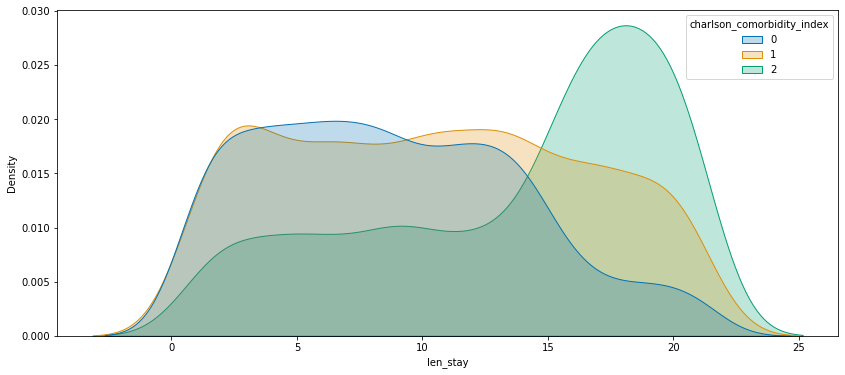

In [147]:
plt_df = all_df[['charlson_comorbidity_index', 'age','len_stay']]
plt_df['charlson_comorbidity_index'] = plt_df['charlson_comorbidity_index'].astype(int).astype(str)
f,ax = plt.subplots(figsize=(14,6))
sns.set_palette("colorblind")
sns.kdeplot(data=plt_df, x='len_stay', hue = 'charlson_comorbidity_index', hue_order = ['0','1','2'], fill = True)
plt.show()

In [183]:
g_df = all_df[['charlson_comorbidity_index','age','len_stay','sex']].groupby(['charlson_comorbidity_index','age','len_stay']).count()

In [184]:
g_df = g_df.reset_index()

In [205]:
g_df = g_df.astype(int)

In [224]:
g_df

,charlson_comorbidity_index,age,len_stay,sex
0,0,39,1,1
1,0,39,19,1
2,0,41,12,1
3,0,41,13,2
4,0,42,1,1
...,...,...,...,...
1276,2,69,11,1
1277,2,69,20,1
1278,2,70,12,1
1279,2,71,5,1


In [212]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X1, Y1)

<IPython.core.display.Javascript object>


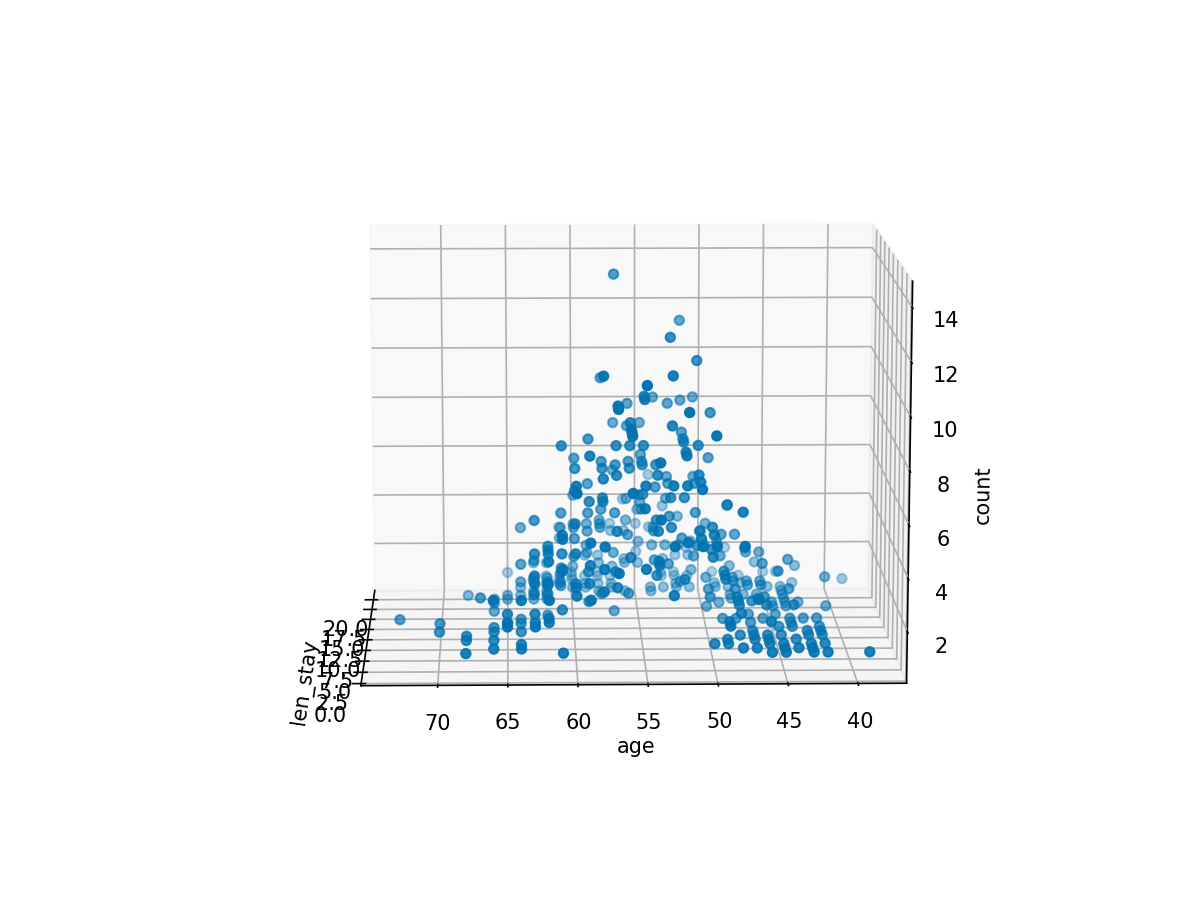

In [232]:
g_df0 = g_df[g_df['charlson_comorbidity_index']== 0]
x0 = g_df0['len_stay']
y0 = g_df0['age']
z0 = g_df0['sex']

plt.figure(figsize = (8, 6))
plt_axes = plt.axes(projection = '3d')
ax.set_title("CCI = 0")
plt_axes.scatter3D(x0, y0, z0)
plt_axes.set_xlabel('len_stay')
plt_axes.set_ylabel('age')
plt_axes.set_zlabel('count')
plt.show()

<IPython.core.display.Javascript object>


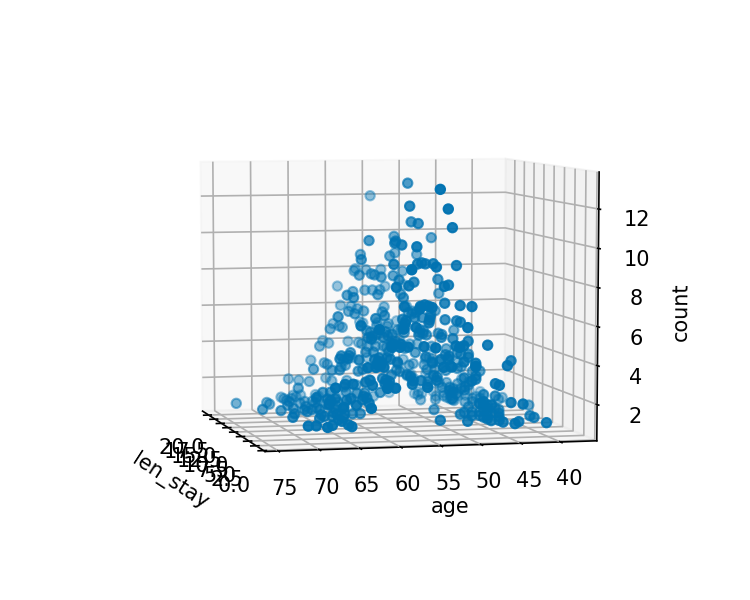

In [229]:
g_df1 = g_df[g_df['charlson_comorbidity_index']== 1]
x1 = g_df1['len_stay']
y1 = g_df1['age']
z1 = g_df1['sex']

plt.figure(figsize = (10, 8))
plt_axes = plt.axes(projection = '3d')
ax.set_title("CCI = 0")
plt_axes.scatter3D(x1, y1, z1)
plt_axes.set_xlabel('len_stay')
plt_axes.set_ylabel('age')
plt_axes.set_zlabel('count')
plt.show()

<IPython.core.display.Javascript object>


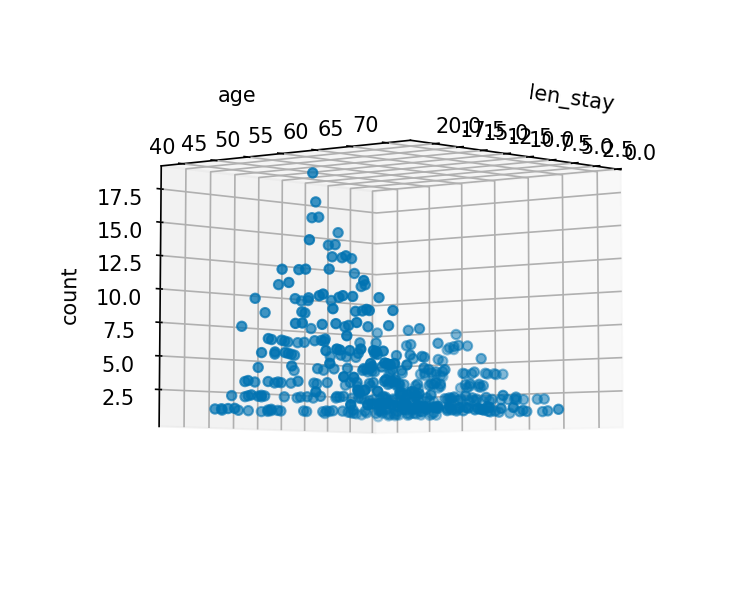

In [230]:
g_df2 = g_df[g_df['charlson_comorbidity_index']== 2]
x2 = g_df2['len_stay']
y2 = g_df2['age']
z2 = g_df2['sex']

plt.figure(figsize = (10, 8))
plt_axes = plt.axes(projection = '3d')
ax.set_title("CCI = 0")
plt_axes.scatter3D(x2, y2, z2)
plt_axes.set_xlabel('len_stay')
plt_axes.set_ylabel('age')
plt_axes.set_zlabel('count')
plt.show()

### Step 6:
Fit a statistical model of your choosing to predict the result_value of the “Hemoglobin” lab tests and evaluate its performance. Explain your choices and how you might improve the model if you had to iterate on it. What other clinical variables would you be interested in adding to the model (they don’t have to be in the provided datasets)?